# INTRODUCCION

### Objetivos del clustering de tiendas según ventas por categorías y departamentos de productos:

1\. **Identificar patrones de ventas regionales**: Permite descubrir diferencias en el comportamiento de compra en distintas tiendas o regiones, lo que puede ayudar a ajustar la estrategia de productos por zona.

2\. **Optimizar el inventario y el abastecimiento**: Agrupar tiendas con patrones de ventas similares facilita la planificación del inventario, asegurando que los productos más demandados estén disponibles donde son más necesarios.

3\. **Segmentación de estrategias de marketing**: Al entender cómo se comportan las ventas de diferentes categorías y departamentos, se pueden diseñar campañas de marketing más efectivas y dirigidas a grupos específicos de tiendas.

4\. **Análisis de rendimiento por categoría**: El clustering permite identificar tiendas con alto rendimiento en ciertas categorías, lo que puede servir de referencia para optimizar el rendimiento en otras tiendas.

5\. **Personalización de promociones**: Facilita la creación de promociones adaptadas a las tiendas que comparten características de ventas similares, maximizando el impacto de las campañas promocionales.

## Caracteristicas

Las características creadas para el clustering de tiendas según la performance en ventas por categoría tienen como objetivo capturar cómo cada tienda se comporta en relación con los productos de distintas categorías. A continuación se describen brevemente:

1\. **Total de ventas por categoría (`category_total_sales`)**: Esta característica mide el valor total de las ventas en cada tienda para una categoría específica. Nos permite identificar qué tiendas generan más ingresos en determinadas categorías, lo que puede revelar especializaciones.

2\. **Unidades vendidas por categoría (`category_total_units`)**: Esta característica indica la cantidad total de unidades vendidas en una categoría por tienda. Es útil para entender el volumen de ventas y qué categorías son más populares en términos de cantidad de productos vendidos, independientemente del valor monetario.

3\. **Precio promedio de la categoría (`category_avg_price`)**: Esta característica mide el precio promedio de los productos vendidos en una categoría dentro de cada tienda. Permite ver si ciertas tiendas tienden a vender productos más caros o más baratos en determinadas categorías.

4\. **Número de días vendiendo productos de la categoría (`category_num_days_selling`)**: Representa el número de días en que se realizaron ventas en una categoría. Esto nos ayuda a entender si las ventas de ciertas categorías son consistentes o esporádicas en cada tienda.

5\. **Proporción de ventas por categoría (`category_sales_share`)**: Calcula la proporción de ventas de una categoría respecto al total de ventas de la tienda. Esta métrica es clave para identificar la dependencia de una tienda en una o varias categorías, lo que puede resaltar si una tienda se especializa en determinadas áreas.

Estas características son útiles para agrupar tiendas que comparten patrones similares de ventas por categorías, permitiendo identificar especializaciones, estrategias de producto o incluso nichos de mercado.

# INIT

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerias

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math

# SK
# Kmeans & PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score

# MODULES PATH
import sys
sys.path.append('/content/drive/MyDrive/TFM_Retail_Repo/03_Clustering')

from modules.get_data import get_data

import warnings

# Omitir todos los warnings
warnings.filterwarnings('ignore')

## Importacion datos

In [27]:
df_cal = get_data('exp_calendar.csv')
df_items = get_data('exp_items.csv')
df_shops = get_data('exp_shops.csv')
df = get_data('daily_sales_with_events.csv') # Vamos a probar con diarias -> filtramos por años para que no pete la creacion de caracteristicas

In [28]:
# Seleccionar solo años 2014 a 2015 de df_s
df = df[(df['year'] >= 2014) & (df['year'] <= 2015)]

# Cambiamos NaN de event por None
df['event'] = df['event'].fillna('None')

display(df.shape)

(8217627, 12)

In [29]:
# Añadimos departament y category desde df_items a df usando la columna 'item'
df = pd.merge(df, df_items[['item', 'department', 'category']], on='item', how='left')

In [30]:
df_origin = df.copy() # Para recuperlo si hace falta

___
___

## Functions

In [31]:
FIGSIZE = (12, 6)
CLUSTER_COL = 'cluster'
SCALER = RobustScaler

In [32]:
# FUNCTIONS HELPERS
def preprocess_features(data, Scaler=SCALER):
  scaler = Scaler()

  scaled_data = scaler.fit_transform(data)
  return pd.DataFrame(scaled_data, columns=data.columns), scaler

# KMEANS init
def init_kmeans(k):
  return KMeans(n_clusters=k, random_state=42, init="random", n_init="auto")

In [33]:
def features_creation(data, level='category'):
    # Ordenar el DataFrame por 'store_code' y 'date' para asegurar un cálculo correcto
    data = data.sort_values(['store_code', 'date'])

    # Filtrar las categorías válidas (excluir NaN y 'None')
    # valid_levels = data[~data[level].isin([None, 'None'])][level].unique()
    valid_levels = data[~data[level].isin([None, 'None'])][level].unique()

    # Inicializar un DataFrame con solo la columna 'store_code' para almacenar todas las características
    level_features = pd.DataFrame(data['store_code'].unique(), columns=['store_code'])

    # Calcular características para cada categoría
    for val in valid_levels:
        # Filtrar datos por la categoría actual
        level_data = data[data[level] == val]

        # Calcular las características agregadas para cada tienda en esta categoría
        level_aggregates = level_data.groupby('store_code').agg({
            'total_sales': 'sum',   # Ventas totales por categoría
            'units': 'sum',         # Unidades vendidas por categoría
            'sell_price': 'mean',   # Precio promedio de los productos en la categoría
            'date': 'count'         # Número de días con ventas en esta categoría
        }).rename(columns={
            'total_sales': f'{val}_total_sales',
            'units': f'{val}_total_units',
            'sell_price': f'{val}_avg_price',
            'date': f'{val}_num_days_selling'
        }).reset_index()

        # Calcular las proporciones de ventas de esta categoría sobre las ventas totales de la tienda
        total_sales_by_store = data.groupby('store_code')['total_sales'].sum().reset_index().rename(columns={'total_sales': 'total_sales_store'})
        level_aggregates = level_aggregates.merge(total_sales_by_store, on='store_code')
        level_aggregates[f'{val}_sales_share'] = level_aggregates[f'{val}_total_sales'] / level_aggregates['total_sales_store']

        # Eliminar la columna temporal 'total_sales_store'
        level_aggregates.drop(columns=['total_sales_store'], inplace=True)

        # Merge las nuevas características en el DataFrame principal de level_features
        level_features = level_features.merge(level_aggregates, on='store_code', how='left')

    # Seleccionar solo las características creadas para las categorías
    features = list(level_features.columns)

    return level_features, features


In [34]:
# Limpieza de features
def clean_features(data, corr_threshold=0.9):
    """
    Limpia las características del DataFrame eliminando las columnas numéricas altamente correlacionadas
    y las columnas constantes.

    Parameters:
    data (pd.DataFrame): El DataFrame que contiene las características.
    corr_threshold (float): El umbral de correlación para eliminar columnas altamente correlacionadas.

    Returns:
    columnas a eliminar
    """
    # 1. Eliminar columnas constantes
    print(f"Eliminando columnas constantes...")
    const_columns = [col for col in data.columns if data[col].nunique() <= 1]
    data_cleaned = data.drop(columns=const_columns)

    # 2. Eliminar columnas altamente correlacionadas
    print(f"Eliminando columnas altamente correlacionadas (umbral={corr_threshold})...")
    numeric_cols = data_cleaned.select_dtypes(include=np.number)
    corr_matrix = numeric_cols.corr().abs()

    # Crea un set para almacenar columnas que serán eliminadas
    drop_cols = set()

    # Iterar sobre la matriz de correlación superior (triangular)
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > corr_threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]

                # Decidir qué columna eliminar (nos quedamos con la de mayor varianza)
                var_i = data_cleaned[colname_i].var()
                var_j = data_cleaned[colname_j].var()

                if var_i > var_j:
                    drop_cols.add(colname_j)
                else:
                    drop_cols.add(colname_i)

    # Mostrar resumen de lo eliminado
    print(f"Columnas eliminadas: {const_columns + list(drop_cols)}")

    return (const_columns + list(drop_cols))


In [35]:
# 1. Preparación de datos
def prepare_data(data):
    data['date'] = pd.to_datetime(data['date'])
    # Renombramos raw_earn a total_sales
    data.rename(columns={'raw_earn': 'total_sales'}, inplace=True)
    return data

# 3. Segmentación de productos usando K-means con RobustScaler
# 3.1 - Grafico silueta
def plot_silhouette(data_scaled, ran=20, level=None):

  silhouette_scores = []

  for k in range(2, ran):
      kmeans = init_kmeans(k)
      kmeans.fit(data_scaled)
      silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

  title = "Silhouette score"
  if level:
    title += f" para la categoria {level}"

  fig = px.line(
      x=range(2, ran),
      y=silhouette_scores,
      title=title,
      labels={"x": "k", "y": "Silhouette score"},
  )
  fig.show()

# 3.2 - Segementacion con optimal_k
def segment_products_kmeans(data_dict, n_clusters=3):

    # FEATURE TOOLS -> helper
    X = data_dict['df_features']
    features = data_dict['features']
    X_scaled = data_dict['X_scaled']
    scaler = data_dict['scaler']
    # END FEATURE TOOLS

    # Aplica Kmeans sobre DF scalado -> helper
    kmeans = init_kmeans(n_clusters)
    X[CLUSTER_COL] = kmeans.fit_predict(X_scaled)

    # Calcula Silueta
    silhouette_avg = silhouette_score(X_scaled, X[CLUSTER_COL])
    print(f"El score de silueta promedio es: {silhouette_avg}")

    # Obtiene centroides y los devuelve en un DF
    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centroid_df = pd.DataFrame(centroids, columns=features)
    centroid_df[CLUSTER_COL] = range(n_clusters)

    return X, centroid_df

In [36]:
# Visualizacion con reduccion de dimensionalidad
def pca_and_plot_clusters(data, n_clusters, detail=None):
    """
    Realiza reducción de dimensionalidad con PCA a 2 componentes principales,
    muestra la varianza acumulada y dibuja un scatter plot de los clusters.

    Parámetros:
    - data: DataFrame con las características (sin la columna de clusters).
    - n_clusters: Número de clusters para KMeans.
    """
    # Rellenamos si hay nan con 0 en data
    if data.isna().any().any():
      data = data.fillna(0)
    # Preprocesar las características (escalado)
    X_scaled, scaler = preprocess_features(data, Scaler=RobustScaler)

    # Aplicar PCA para reducir a 2 dimensiones
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Mostrar la varianza explicada acumulada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()
    print(f"Varianza explicada por cada componente principal: {explained_variance}")
    print(f"Varianza acumulada: {cumulative_variance}")

    # Aplicar KMeans en las 2 dimensiones obtenidas por PCA
    kmeans = init_kmeans(n_clusters)
    clusters = kmeans.fit_predict(X_pca)

    # Crear DataFrame para visualización
    pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
    pca_df['Cluster'] = clusters

    # Obtener los centroides del KMeans en las dimensiones reducidas por PCA
    centroids = kmeans.cluster_centers_

    # Plotear los clusters en un scatter plot
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_df, palette='bright', s=100, alpha=0.7)

    # Añadir los centroides al scatter plot
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroides')

    # Añadir leyenda y título
    plt.legend()
    title = f'Clusters visualizados en 2D con PCA'
    if detail:
      title += f' : {detail}'
    plt.title(title)
    plt.show()

    return pca_df, centroids

In [37]:
def plot_cluster_bars(data, target_col):
    # Filtrar solo las columnas numéricas
    numeric_cols = data.select_dtypes(include='number').columns.tolist()

    # Remover la columna del cluster de las columnas numéricas si está incluida
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    # Agrupar por la columna del cluster y calcular la media de las columnas numéricas
    cluster_means = data.groupby(target_col)[numeric_cols].mean()

    # Configurar el gráfico de barras
    cluster_means.plot(kind='bar', figsize=(10, 4))

    # Etiquetas y título
    plt.title('Comparación de Variables Numéricas por Cluster')
    plt.xlabel('Clusters')
    plt.ylabel('Media de las Variables')
    plt.xticks(rotation=0)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# CATEGORIAS

## Copy data

In [38]:
df = df_origin.copy()

In [39]:
print('done')

done


## Clustering

In [40]:
# df_stores_features = create_store_features(df, df_shops)
sales_data = prepare_data(df)

In [41]:
# Creacion caracteristicas para segmentacion de TODAS las categorias
target='category'

df_features, features = features_creation(df, level=target)

In [42]:
pd.options.display.float_format = '{:.2f}'.format

# df_features.columns.tolist()

In [43]:
# Inicializamos df_shops_with_clusters
df_shops_with_clusters = df_shops[['store_code']].copy()

In [44]:
# Guardamos lista de categorias unicos para loopear
categories_list = df[target].unique().tolist()

category: ACCESORIES


El score de silueta promedio es: 0.40095150139787633


,0,1
ACCESORIES_total_sales,1581625.50,897167.78
ACCESORIES_total_units,293227.86,173802.00
ACCESORIES_avg_price,7.35,6.92
ACCESORIES_num_days_selling,118343.71,85953.00
ACCESORIES_sales_share,0.16,0.11
cluster,0.00,1.00


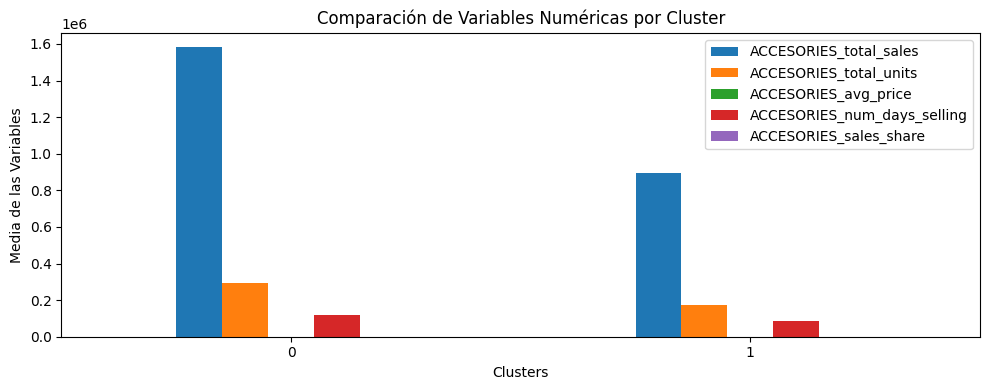

Varianza explicada por cada componente principal: [0.76887659 0.17353784]
Varianza acumulada: [0.76887659 0.94241443]


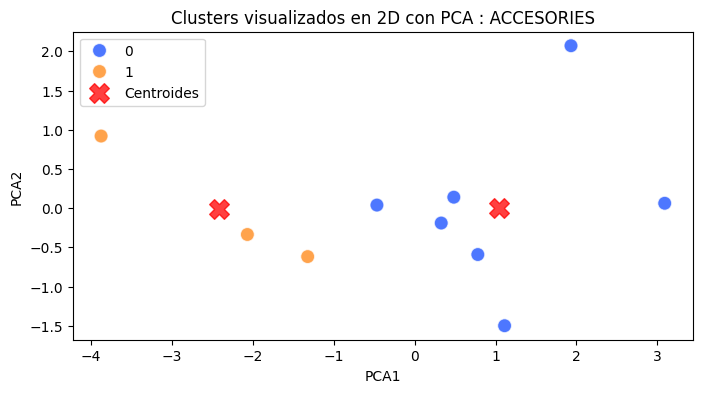


ACCESORIES DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

category: HOME_&_GARDEN


El score de silueta promedio es: 0.6065669729832559


,0,1
HOME_&_GARDEN_total_sales,2741186.93,5871604.70
HOME_&_GARDEN_total_units,567110.33,1203213.00
HOME_&_GARDEN_avg_price,5.86,6.22
HOME_&_GARDEN_num_days_selling,245545.56,333790.00
HOME_&_GARDEN_sales_share,0.30,0.35
cluster,0.00,1.00


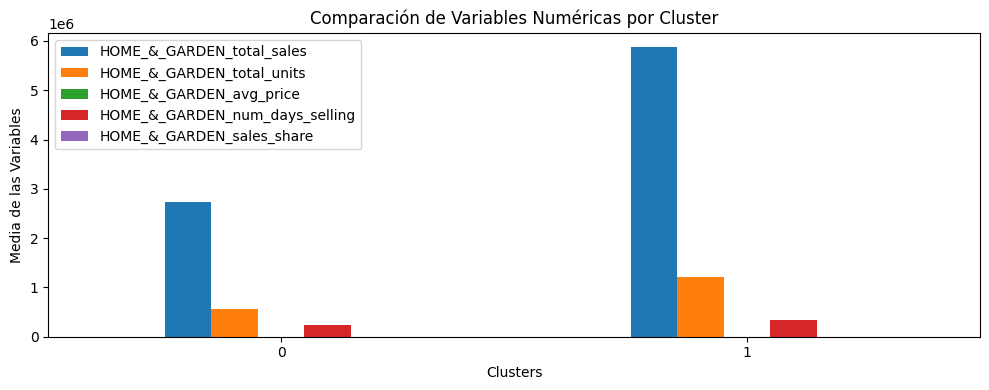

Varianza explicada por cada componente principal: [0.87740152 0.08084281]
Varianza acumulada: [0.87740152 0.95824433]


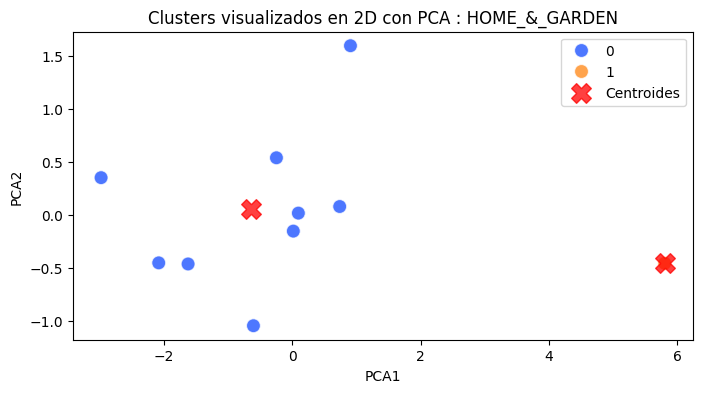


HOME_&_GARDEN DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

category: SUPERMARKET


El score de silueta promedio es: 0.331506078549867


,0,1
SUPERMARKET_total_sales,7375136.96,4640132.45
SUPERMARKET_total_units,2426281.67,1532933.57
SUPERMARKET_avg_price,3.68,3.61
SUPERMARKET_num_days_selling,524932.00,430409.43
SUPERMARKET_sales_share,0.57,0.54
cluster,0.00,1.00


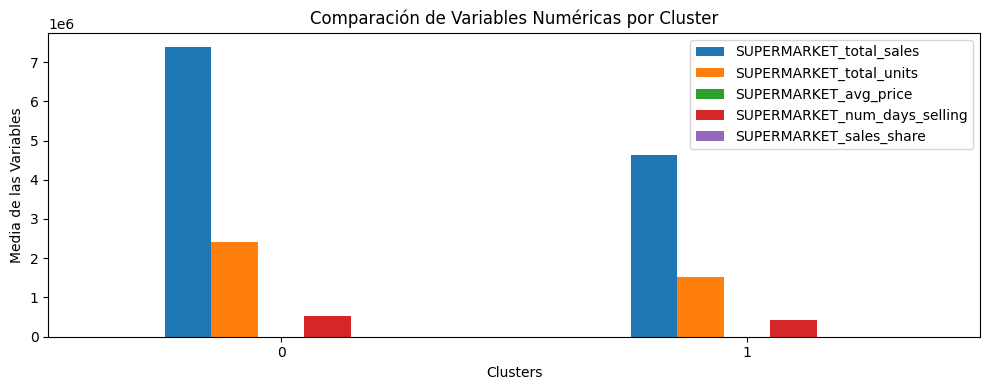

Varianza explicada por cada componente principal: [0.59366833 0.3299764 ]
Varianza acumulada: [0.59366833 0.92364473]


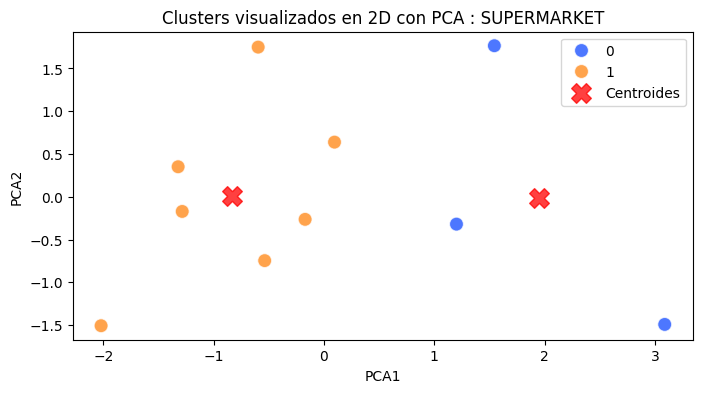


SUPERMARKET DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::



In [45]:
for category in categories_list:
  print(f'category: {category}')

  # Seleccionamos caracteristicas relativas al categoria
  selected_features = [feature for feature in features if feature.startswith(category)]

  # Quitamos NaN => shops que no tienen que ver con el categoria
  df_features.dropna(subset=selected_features, inplace=True)

  # # Limpiamos features high correlated y constant
  # cols_to_drop = clean_features(df_features[selected_features], corr_threshold=0.9)

  # # Actualizamos selected_features después de limpieza
  # selected_features = list(set(selected_features) - set(cols_to_drop))

  cols_to_keep = ['store_code'] + selected_features
  df_to_scale = df_features[cols_to_keep]

  # Preprocesamiento
  # scaled_df, scaler = preprocess_features(df_features[selected_features], Scaler=SCALER)
  scaled_df, scaler = preprocess_features(df_to_scale[selected_features], Scaler=SCALER)

  # Silhouette
  length = scaled_df.shape[0] # Por si son menos tiendas del total (alguna no tiene ventas en el categoria)
  plot_silhouette(scaled_df, ran=length, level=category)

  optimal_k = 2 # segun silueta

  data = {
      # 'df_features': df_features,
      'df_features': df_to_scale,
      'features': selected_features,
      'X_scaled': scaled_df,
      'scaler': scaler
  }

  product_segments, centroid_df = segment_products_kmeans(data, n_clusters=optimal_k)

  # Renombramos CLUSTER_COL de product_segmentes a {category}
  product_segments = product_segments.rename(columns={CLUSTER_COL: f'{category}'})

  # Añadimos columna cluster a df_shops_with_clusters desde product_segments usando columna 'item'
  df_shops_with_clusters = df_shops_with_clusters.merge(product_segments[['store_code', category]], on='store_code', how='left')

  # # visualizacion de centroides
  display(centroid_df.T)
  # # plot_cluster_bars(centroid_df, target_col='cluster')
  feats = centroid_df.columns.tolist()
  # # feats.remove(f'{category}_total_sales') # Quitamos total_sales para ver mejor el resto de barras
  plot_cluster_bars(centroid_df[feats], target_col=CLUSTER_COL)
  # cents = scaler.inverse_transform(centroid_df[selected_features])
  # cents = pd.DataFrame(cents, columns=selected_features)
  # cents[CLUSTER_COL] = centroid_df[CLUSTER_COL]
  # feats = cents.columns.tolist()
  # # feats.remove(f'{category}_total_sales') # Quitamos total_sales para ver mejor el resto de barras
  # plot_cluster_bars(cents[feats], target_col=CLUSTER_COL)

  # Visualizacion 2D
  pca_df, pca_centroids = pca_and_plot_clusters(data['df_features'][selected_features], n_clusters=optimal_k, detail=category)

  print(f'\n{category} DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::\n')

In [46]:
# ordenamos alfabeticamente por store_code
df_shops_with_clusters.sort_values(by='store_code', inplace=True)

df_shops_with_clusters

,store_code,ACCESORIES,HOME_&_GARDEN,SUPERMARKET
4,BOS_1,1,0,1
5,BOS_2,0,0,1
6,BOS_3,0,0,1
0,NYC_1,0,0,0
1,NYC_2,0,0,1
2,NYC_3,0,1,0
3,NYC_4,0,0,1
7,PHI_1,0,0,1
8,PHI_2,1,0,0
9,PHI_3,1,0,1


 ## Comprobación conclusiones

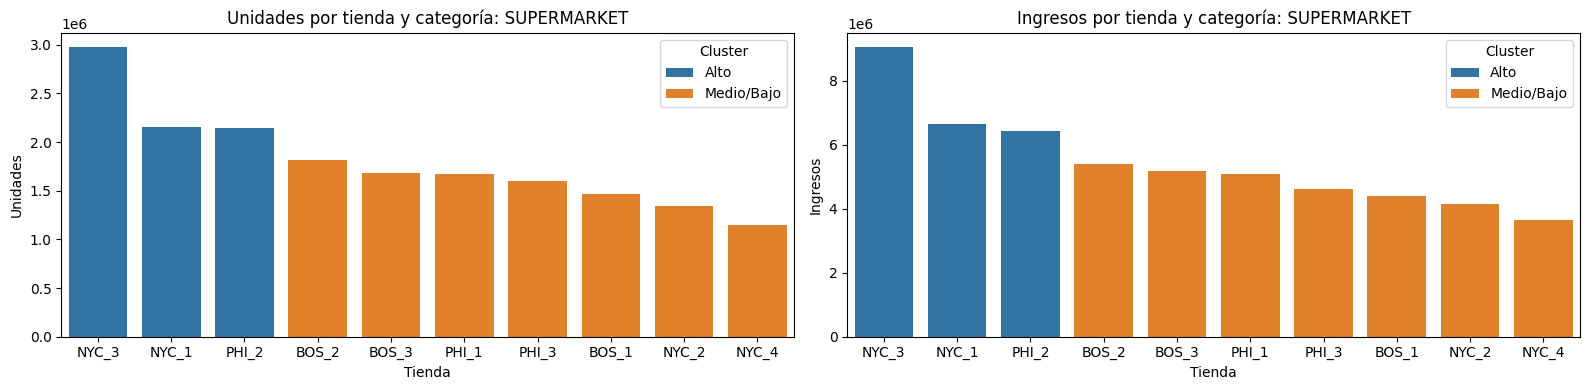

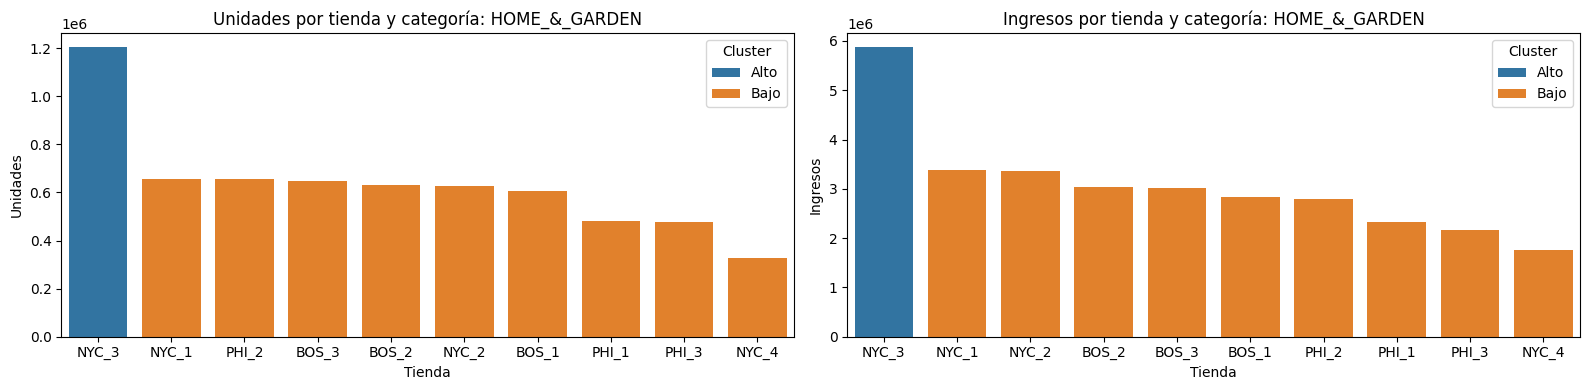

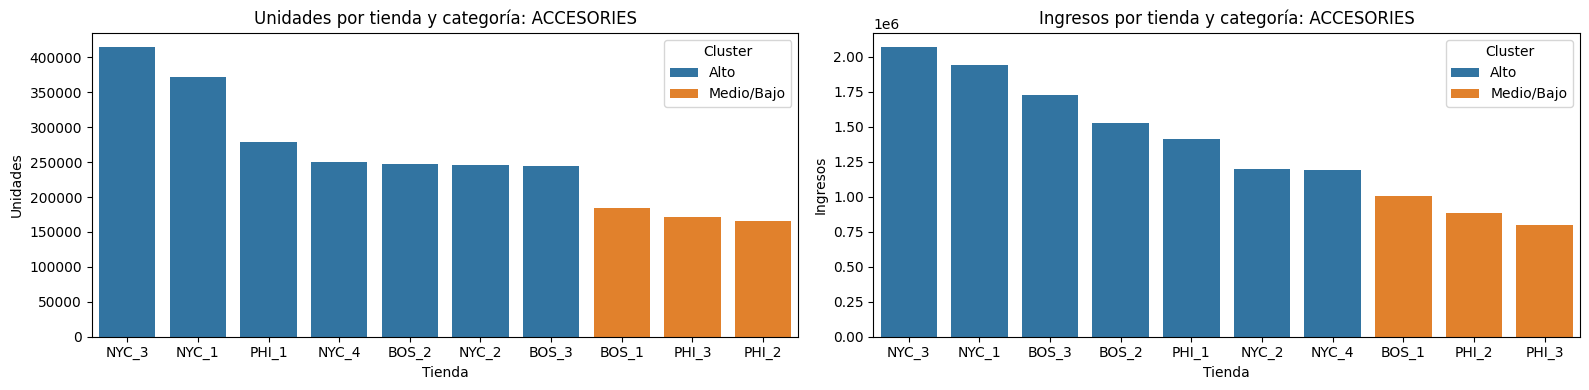

In [47]:
shops_clusters = df_shops_with_clusters.copy()

# Creamos diccionario con etiquetas para clusters
clusters_dict = {
    'ACCESORIES': {0: 'Alto', 1: 'Medio/Bajo'},
    'HOME_&_GARDEN': {0: 'Bajo', 1: 'Alto'},
    'SUPERMARKET': {0: 'Alto', 1: 'Medio/Bajo'},
}

# Cambiamos valores de columnas numéricas de shop_clusters según el diccionario creado con nombres de columnas
for col, mapping in clusters_dict.items():
    shops_clusters[col] = shops_clusters[col].map(mapping)

# Usamos la función 'melt' para transformar el DataFrame a formato largo
shops_clusters_long = shops_clusters.melt(id_vars=['store_code'],
                                          var_name='category',
                                          value_name='cluster_category')

test = df_origin.copy()

# Agrupamos por store_code y sumamos por cada categoría el total de units y raw_earn
test = test.groupby(['store_code', 'category'])[['units', 'raw_earn']].sum().reset_index()

# Añadimos la columna cluster_category a test desde shops_clusters_long usando store_code y category
test = test.merge(shops_clusters_long[['store_code', 'category', 'cluster_category']], on=['store_code', 'category'], how='left')

# Ordenamos por tienda y categoría
test.sort_values(by=['category', 'raw_earn'], ascending=False, inplace=True)

# Lista de categorías únicas
cats_list = test['category'].unique().tolist()

# Graficamos dos gráficos por fila: unidades a la izquierda y raw_earn a la derecha
for cat in cats_list:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # Ordenamos por units
    test.sort_values(by=['units'], ascending=False, inplace=True)

    # Gráfico para unidades
    sns.barplot(ax=axes[0], x='store_code', y='units', hue='cluster_category', data=test[test['category'] == cat])
    axes[0].set_title(f'Unidades por tienda y categoría: {cat}')
    axes[0].set_xlabel('Tienda')
    axes[0].set_ylabel('Unidades')
    axes[0].legend(title='Cluster')

    # Ordenamos por units
    test.sort_values(by=['raw_earn'], ascending=False, inplace=True)

    # Gráfico para ingresos
    sns.barplot(ax=axes[1], x='store_code', y='raw_earn', hue='cluster_category', data=test[test['category'] == cat])
    axes[1].set_title(f'Ingresos por tienda y categoría: {cat}')
    axes[1].set_xlabel('Tienda')
    axes[1].set_ylabel('Ingresos')
    axes[1].legend(title='Cluster')

    # Ajustamos la disposición
    plt.tight_layout()
    plt.show()


# DEPARTAMENTOS

## Copy data

In [48]:
df = df_origin.copy()

## Clustering

In [49]:
sales_data = prepare_data(df)

In [50]:
# Creacion caracteristicas para segmentacion de TODAS las departamentos
target = 'department'

df_features, features = features_creation(df, level=target)

In [51]:
# Guardamos lista de categorias unicos para loopear
departments_list = df[target].unique().tolist()

department: ACCESORIES_1


El score de silueta promedio es: 0.3925253387103101


,0,1
ACCESORIES_1_total_sales,1500736.77,838108.06
ACCESORIES_1_total_units,264920.14,153820.67
ACCESORIES_1_avg_price,8.07,7.59
ACCESORIES_1_num_days_selling,100842.71,72781.33
ACCESORIES_1_sales_share,0.15,0.10
cluster,0.00,1.00


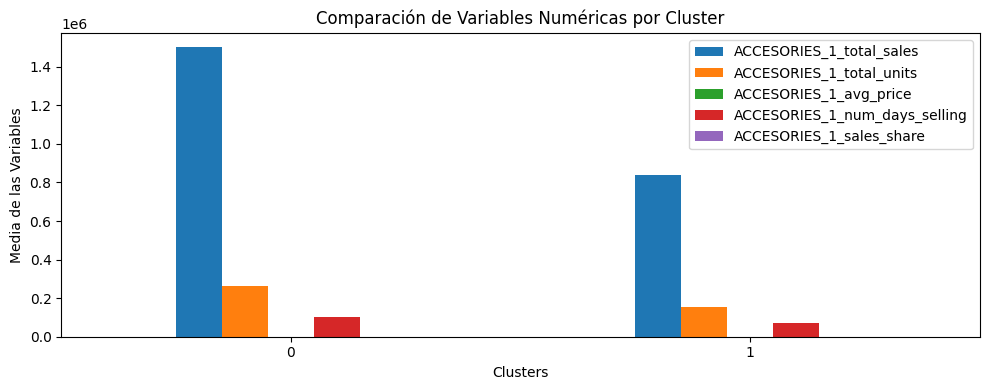

Varianza explicada por cada componente principal: [0.74931769 0.17242998]
Varianza acumulada: [0.74931769 0.92174767]


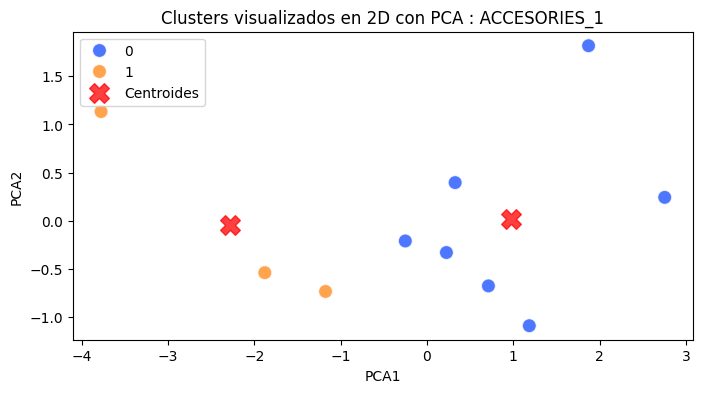


ACCESORIES_1 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

department: ACCESORIES_2


El score de silueta promedio es: 0.3786874084565384


,0,1
ACCESORIES_2_total_sales,61729.40,77492.69
ACCESORIES_2_total_units,22440.00,26652.25
ACCESORIES_2_avg_price,3.13,3.21
ACCESORIES_2_num_days_selling,14242.00,16692.25
ACCESORIES_2_sales_share,0.01,0.01
cluster,0.00,1.00


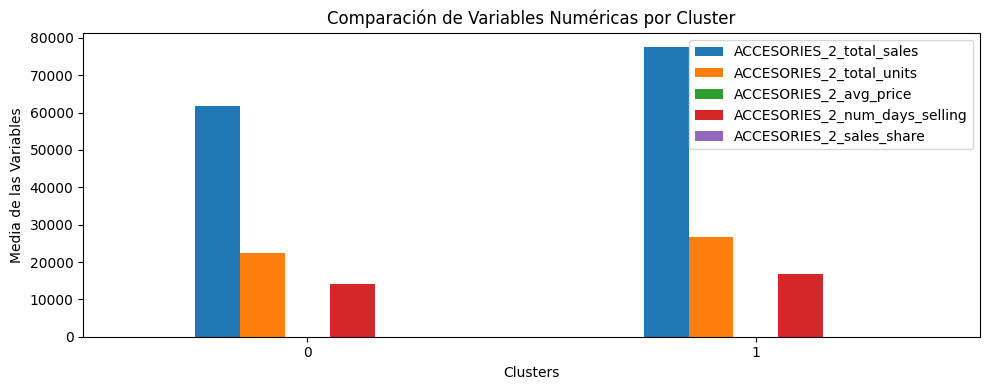

Varianza explicada por cada componente principal: [0.59047233 0.35831549]
Varianza acumulada: [0.59047233 0.94878782]


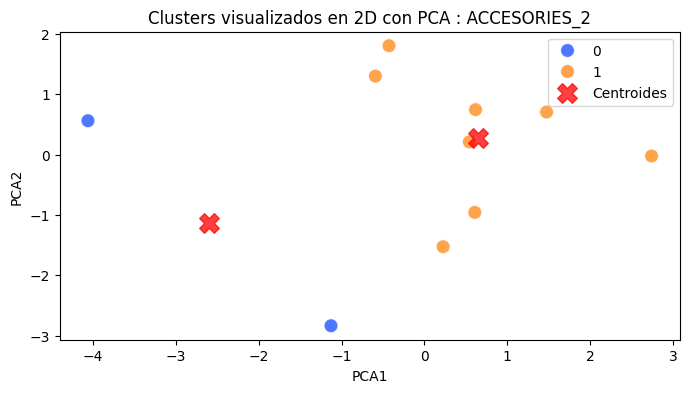


ACCESORIES_2 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

department: HOME_&_GARDEN_1


El score de silueta promedio es: 0.586947497325945


,0,1
HOME_&_GARDEN_1_total_sales,2056513.46,4446765.19
HOME_&_GARDEN_1_total_units,452571.56,972952.00
HOME_&_GARDEN_1_avg_price,5.64,6.00
HOME_&_GARDEN_1_num_days_selling,168769.56,212052.00
HOME_&_GARDEN_1_sales_share,0.23,0.26
cluster,0.00,1.00


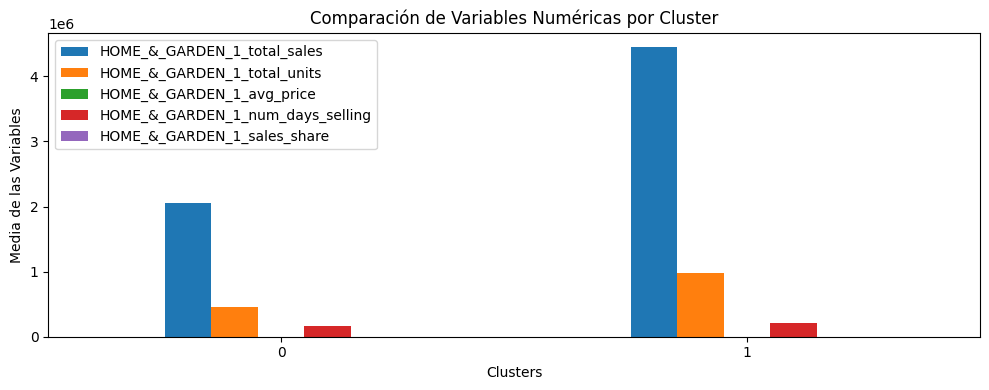

Varianza explicada por cada componente principal: [0.88336311 0.05159019]
Varianza acumulada: [0.88336311 0.9349533 ]


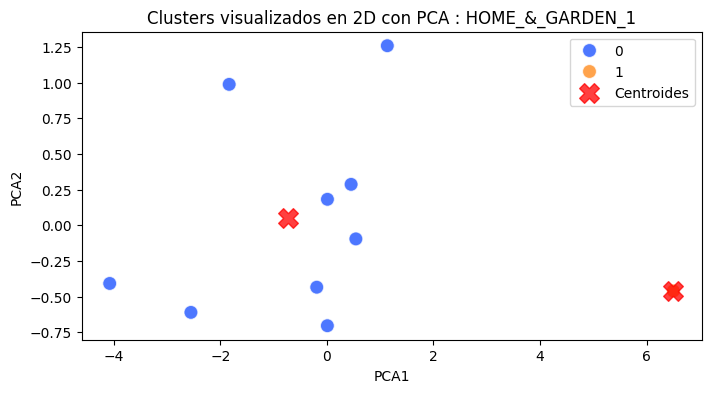


HOME_&_GARDEN_1 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

department: HOME_&_GARDEN_2


El score de silueta promedio es: 0.5793156868652103


,0,1
HOME_&_GARDEN_2_total_sales,625695.60,1290667.99
HOME_&_GARDEN_2_total_units,106051.00,206351.00
HOME_&_GARDEN_2_avg_price,6.27,6.69
HOME_&_GARDEN_2_num_days_selling,73352.50,112951.00
HOME_&_GARDEN_2_sales_share,0.07,0.11
cluster,0.00,1.00


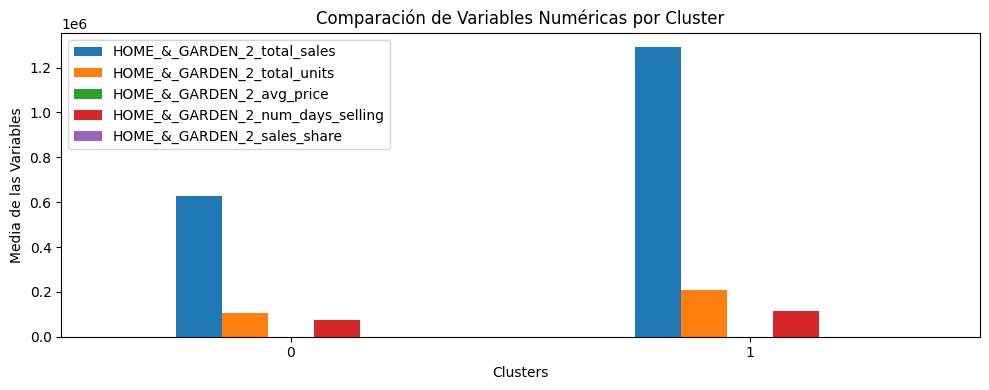

Varianza explicada por cada componente principal: [0.81805294 0.16595067]
Varianza acumulada: [0.81805294 0.98400361]


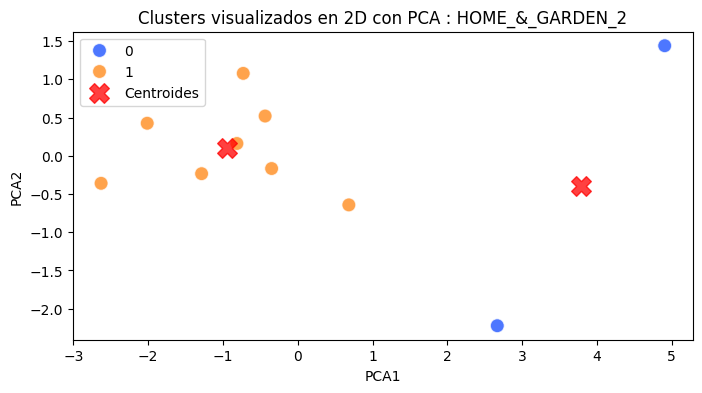


HOME_&_GARDEN_2 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

department: SUPERMARKET_1


El score de silueta promedio es: 0.4846847416824772


,0,1
SUPERMARKET_1_total_sales,889594.24,632043.30
SUPERMARKET_1_total_units,263518.00,200952.89
SUPERMARKET_1_avg_price,3.71,3.63
SUPERMARKET_1_num_days_selling,76205.00,62775.00
SUPERMARKET_1_sales_share,0.10,0.06
cluster,0.00,1.00


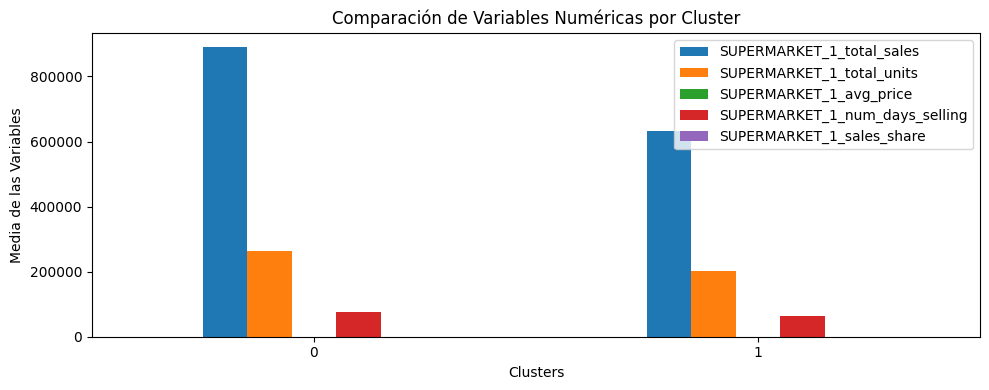

Varianza explicada por cada componente principal: [0.59440909 0.29536918]
Varianza acumulada: [0.59440909 0.88977827]


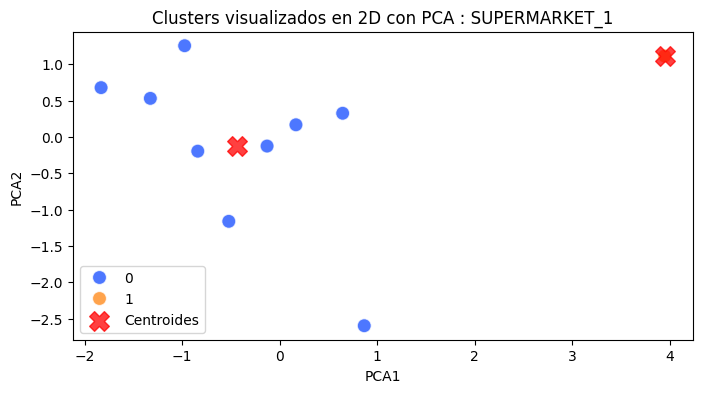


SUPERMARKET_1 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

department: SUPERMARKET_2


El score de silueta promedio es: 0.4233277760748269


,0,1
SUPERMARKET_2_total_sales,2016854.75,1094720.83
SUPERMARKET_2_total_units,491713.50,269460.75
SUPERMARKET_2_avg_price,4.63,4.53
SUPERMARKET_2_num_days_selling,135993.00,103250.00
SUPERMARKET_2_sales_share,0.16,0.12
cluster,0.00,1.00


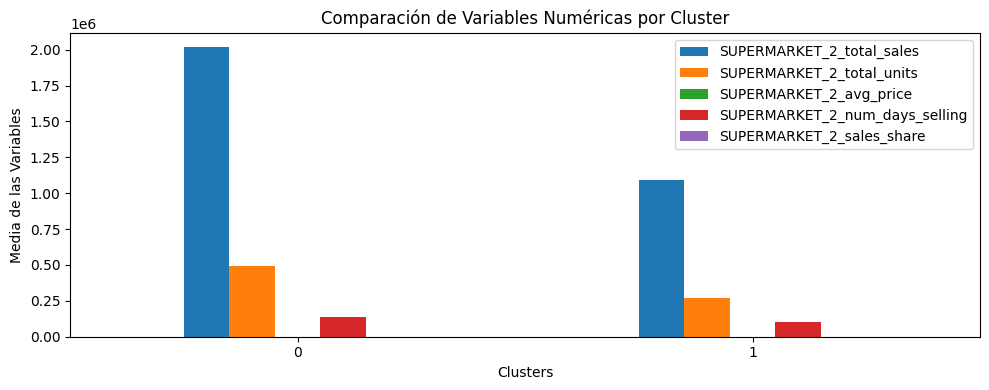

Varianza explicada por cada componente principal: [0.76022958 0.13022199]
Varianza acumulada: [0.76022958 0.89045156]


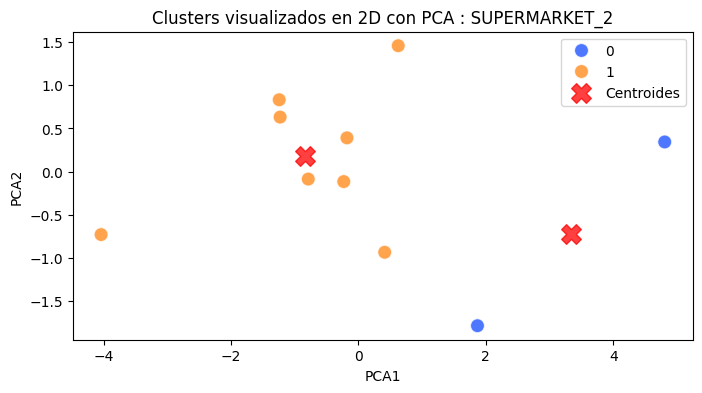


SUPERMARKET_2 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

department: SUPERMARKET_3


El score de silueta promedio es: 0.42056271526729977


,0,1
SUPERMARKET_3_total_sales,3064801.26,5359233.97
SUPERMARKET_3_total_units,1126536.75,1892939.50
SUPERMARKET_3_avg_price,3.26,3.37
SUPERMARKET_3_num_days_selling,271108.12,339815.50
SUPERMARKET_3_sales_share,0.35,0.37
cluster,0.00,1.00


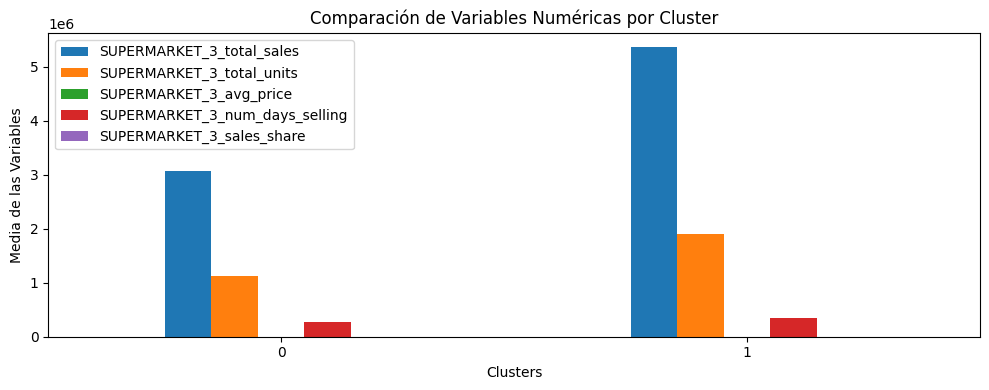

Varianza explicada por cada componente principal: [0.66608216 0.27319827]
Varianza acumulada: [0.66608216 0.93928043]


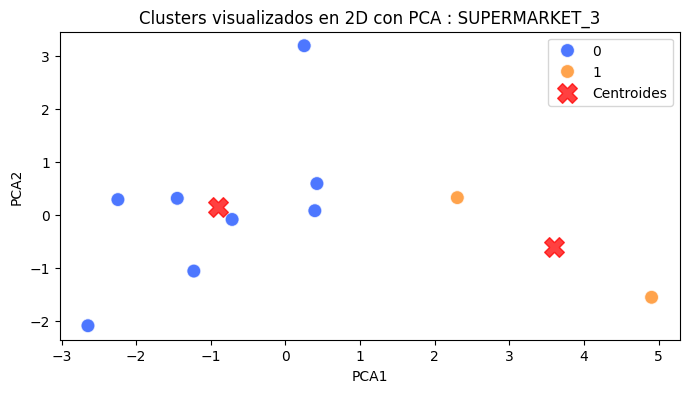


SUPERMARKET_3 DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::



In [52]:
for department in departments_list:
  print(f'department: {department}')

  # Seleccionamos caracteristicas relativas al departamento
  selected_features = [feature for feature in features if feature.startswith(department)]

  # Quitamos NaN => shops que no tienen que ver con el departamento
  df_features.dropna(subset=selected_features, inplace=True)

  # # Limpiamos features high correlated y constant
  # cols_to_drop = clean_features(df_features[selected_features], corr_threshold=0.9)

  # # Actualizamos selected_features después de limpieza
  # selected_features = list(set(selected_features) - set(cols_to_drop))

  cols_to_keep = ['store_code'] + selected_features
  df_to_scale = df_features[cols_to_keep]

  # Preprocesamiento
  scaled_df, scaler = preprocess_features(df_to_scale[selected_features], Scaler=SCALER)

  # Silhouette
  length = scaled_df.shape[0] # Por si son menos tiendas del total (alguna no tiene ventas en el departamento)
  plot_silhouette(scaled_df, ran=length, level=department)

  # Segmentacion con optimal_k
  optimal_k = 2 # Segun grafico de silueta

  data = {
      'df_features': df_to_scale,
      'features': selected_features,
      'X_scaled': scaled_df,
      'scaler': scaler
  }

  product_segments, centroid_df = segment_products_kmeans(data, n_clusters=optimal_k)

  # Renombramos CLUSTER_COL de product_segmentes a {department}
  product_segments = product_segments.rename(columns={CLUSTER_COL: f'{department}'})

  # Añadimos columna cluster a df_shops_with_clusters desde product_segments usando columna 'item'
  df_shops_with_clusters = df_shops_with_clusters.merge(product_segments[['store_code', department]], on='store_code', how='left')

  # visualizacion de centroides
  display(centroid_df.T)
  plot_cluster_bars(centroid_df, target_col='cluster')
  # cents = scaler.inverse_transform(centroid_df[selected_features])
  # cents = pd.DataFrame(cents, columns=selected_features)
  # cents[CLUSTER_COL] = centroid_df[CLUSTER_COL]
  # plot_cluster_bars(cents, target_col='cluster')

  # Visualizacion 2D
  pca_df, pca_centroids = pca_and_plot_clusters(data['df_features'][selected_features], n_clusters=optimal_k, detail=department)

  print(f'\n{department} DONE ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::\n')

In [53]:
df_shops_with_clusters.sort_values(by='store_code', inplace=True)

df_shops_with_clusters

,store_code,ACCESORIES,HOME_&_GARDEN,SUPERMARKET,ACCESORIES_1,ACCESORIES_2,HOME_&_GARDEN_1,HOME_&_GARDEN_2,SUPERMARKET_1,SUPERMARKET_2,SUPERMARKET_3
0,BOS_1,1,0,1,1,1,0,0,1,1,0
1,BOS_2,0,0,1,0,0,0,0,1,1,0
2,BOS_3,0,0,1,0,1,0,0,1,1,0
3,NYC_1,0,0,0,0,1,0,0,1,1,1
4,NYC_2,0,0,1,0,1,0,1,0,1,0
5,NYC_3,0,1,0,0,1,1,1,1,0,1
6,NYC_4,0,0,1,0,0,0,0,1,1,0
7,PHI_1,0,0,1,0,1,0,0,1,1,0
8,PHI_2,1,0,0,1,1,0,0,1,0,0
9,PHI_3,1,0,1,1,1,0,0,1,1,0


# Comprobacion conclusiones

In [69]:
shops_clusters = df_shops_with_clusters.copy()

# Obtenemos listas de categorias y departamentos
cats_list = df_items['category'].unique().tolist()
depts_list = df_items['department'].unique().tolist()

# Creamos diccionario con etiquetas para clusters
clusters_dict = {
    'ACCESORIES': {0: 'Alto', 1: 'Medio/Bajo'},
    'HOME_&_GARDEN': {0: 'Bajo', 1: 'Alto'},
    'SUPERMARKET': {0: 'Alto', 1: 'Medio/Bajo'},
    'ACCESORIES_1': {0: 'Alto', 1: 'Medio/Bajo'},
    'ACCESORIES_2': {0: 'Medio/Bajo', 1: 'Alto'},
    # 'ACCESORIES_2': {0: 'Bajo', 1: 'Alto', 2: 'Medio'},
    'HOME_&_GARDEN_1': {0: 'Bajo', 1: 'Alto'},
    'HOME_&_GARDEN_2': {0: 'Medio/Bajo', 1: 'Alto'},
    'SUPERMARKET_1': {0: 'Alto', 1: 'Medio'},
    # 'SUPERMARKET_1': {0: 'Alto', 1: 'Altisimo', 2: 'Medio'},
    'SUPERMARKET_2': {0: 'Alto', 1: 'Medio'},
    'SUPERMARKET_3': {0: 'Medio', 1: 'Alto'},
}

# Cambiamos valores de columnas numericas de shop_clusters segun diccionario creado con nombres de columnas
for col, mapping in clusters_dict.items():
    shops_clusters[col] = shops_clusters[col].map(mapping)

# Usamos la función 'melt' para transformar el DataFrame a formato largo
selected_cols = ['store_code'] + cats_list

shops_clusters_cats_long = shops_clusters[selected_cols].melt(id_vars=['store_code'],
                                          var_name='category',
                                          value_name='category_cluster')

selected_cols = ['store_code'] + depts_list

shops_clusters_depts_long = shops_clusters[selected_cols].melt(id_vars=['store_code'],
                                          var_name='department',
                                          value_name='department_cluster')

# Mergeamos shops_clusters_cats_long y shops_clusters_depts_long usando 'store_code'
# shops_clusters_long = shops_clusters_cats_long.merge(shops_clusters_depts_long, on='store_code', how='left')

display(shops_clusters_cats_long.head(5))
display(shops_clusters_depts_long.head(5))

,store_code,category,category_cluster
0,BOS_1,ACCESORIES,Medio/Bajo
1,BOS_2,ACCESORIES,Alto
2,BOS_3,ACCESORIES,Alto
3,NYC_1,ACCESORIES,Alto
4,NYC_2,ACCESORIES,Alto


,store_code,department,department_cluster
0,BOS_1,ACCESORIES_1,Medio/Bajo
1,BOS_2,ACCESORIES_1,Alto
2,BOS_3,ACCESORIES_1,Alto
3,NYC_1,ACCESORIES_1,Alto
4,NYC_2,ACCESORIES_1,Alto


# Clusters dict

In [76]:
# agrupamos por tienda
def clusters_dict(data_labeled, target_col):

  # Agrupamos por 'store_code' y combinamos las categorías y sus clusters en un diccionario
  combined = data_labeled.groupby('store_code').apply(
      lambda x: dict(zip(x['category'], x['category_cluster']))
  ).reset_index()

  # Renombramos la columna resultante
  combined.columns = ['store_code', 'category_performance']

  return combined

shops_dict = clusters_dict(shops_clusters_cats_long, 'store_code')

shops_dict

,store_code,category_performance
0,BOS_1,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': ..."
1,BOS_2,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
2,BOS_3,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
3,NYC_1,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
4,NYC_2,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
5,NYC_3,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Alto'..."
6,NYC_4,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
7,PHI_1,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
8,PHI_2,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': ..."
9,PHI_3,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': ..."


In [60]:
# Recuperamos ventas originales
test = df_origin.copy()

def test_clusters(data, data_labeled, target_col, it_list):
    # Agrupamos por store_code y target_col, sumando el total de units y raw_earn
    data = data.groupby(['store_code', target_col])[['units', 'raw_earn']].sum().reset_index()

    # Añadimos columna f'{target_col}_cluster' a data desde data_labeled usando 'store_code'
    data = data.merge(data_labeled[['store_code', target_col, f'{target_col}_cluster']], on=['store_code', target_col], how='left')

    # Ordenamos data por store_code
    data.sort_values(by='store_code', ascending=False, inplace=True)

    # Calculamos el valor máximo de units para usar el mismo límite en el eje y
    max_units = data['units'].max()

    # Creamos gráficos de barras para cada item en it_list
    for item in it_list:
        # Configuración del tamaño de la figura y dos subplots
        fig, axes = plt.subplots(1, 2, figsize=(14, 3))

        # Gráfico para units
        sns.barplot(ax=axes[0], x='store_code', y='units', hue=f'{target_col}_cluster', data=data[data[target_col] == item])
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
        axes[0].set_title(f'Unidades vendidas por tienda y {target_col}: {item}')
        axes[0].set_xlabel('Tienda')
        axes[0].set_ylabel('Unidades')
        axes[0].legend(title='Cluster')
        axes[0].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)
        axes[0].set_ylim(0, max_units)  # Configura el mismo límite superior para el eje y

        # Gráfico para raw_earn
        sns.barplot(ax=axes[1], x='store_code', y='raw_earn', hue=f'{target_col}_cluster', data=data[data[target_col] == item])
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x/1e6)}M'))
        axes[1].set_title(f'Ingresos por tienda y {target_col}: {item}')
        axes[1].set_xlabel('Tienda')
        axes[1].set_ylabel('Ingresos')
        axes[1].legend(title='Cluster')
        axes[1].grid(axis='y', color='gray', linestyle='--', linewidth=0.5)

        # Ajustar la separación entre gráficos
        plt.tight_layout()
        plt.show()


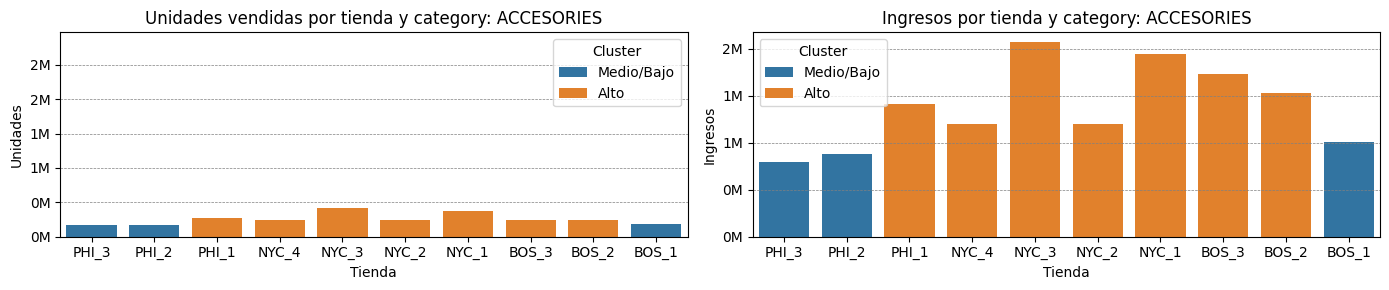

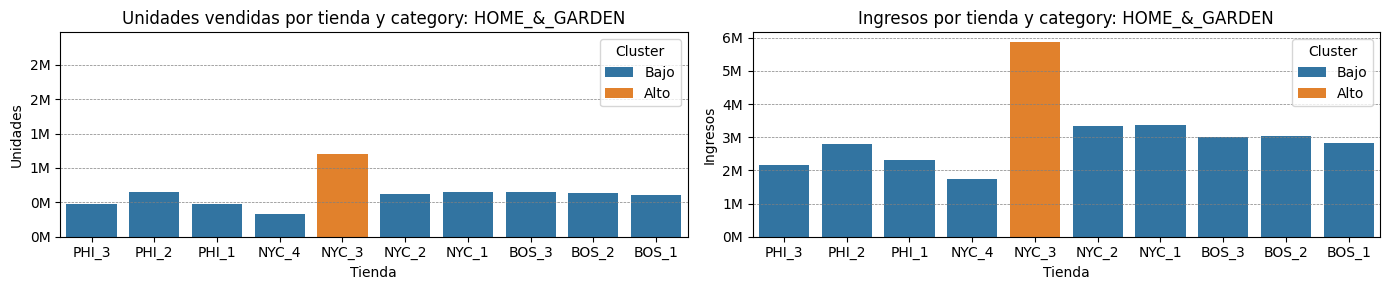

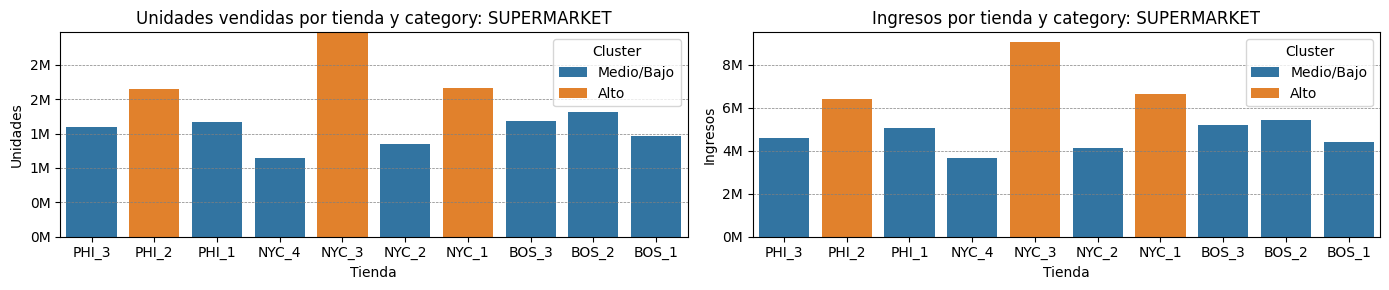

In [61]:
test_clusters(test, shops_clusters_long, target_col='category', it_list=cats_list)

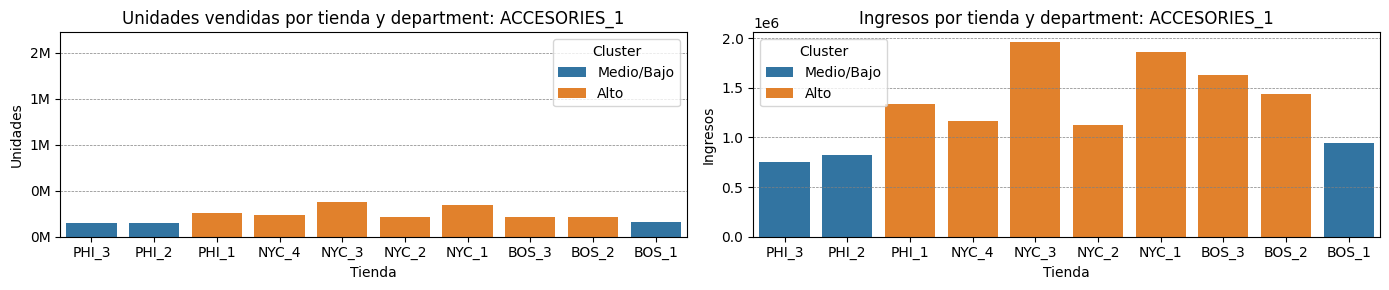

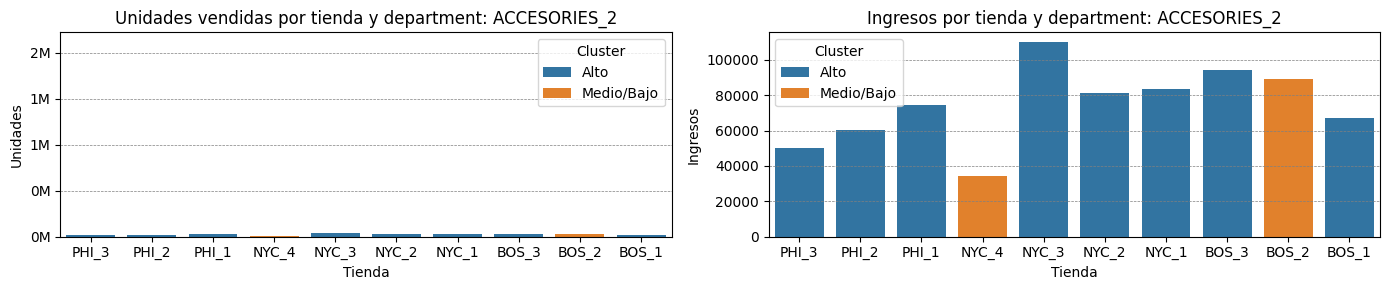

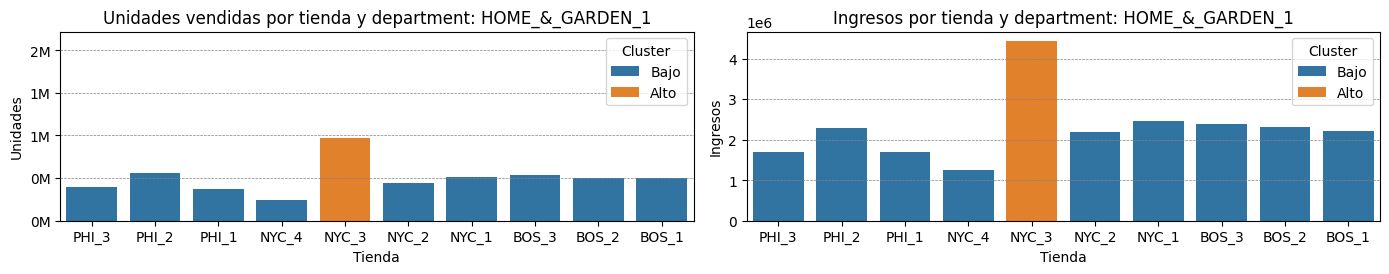

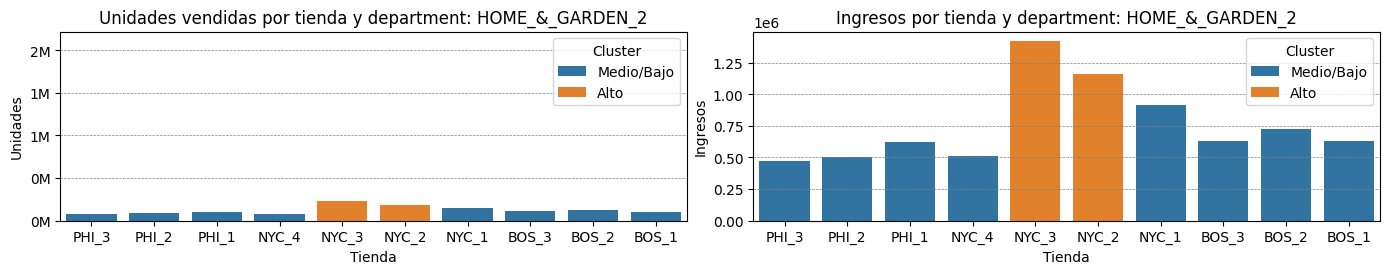

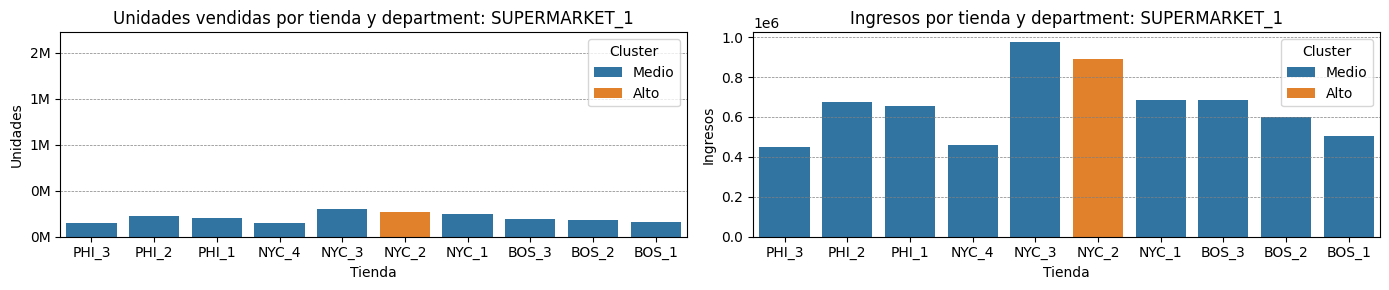

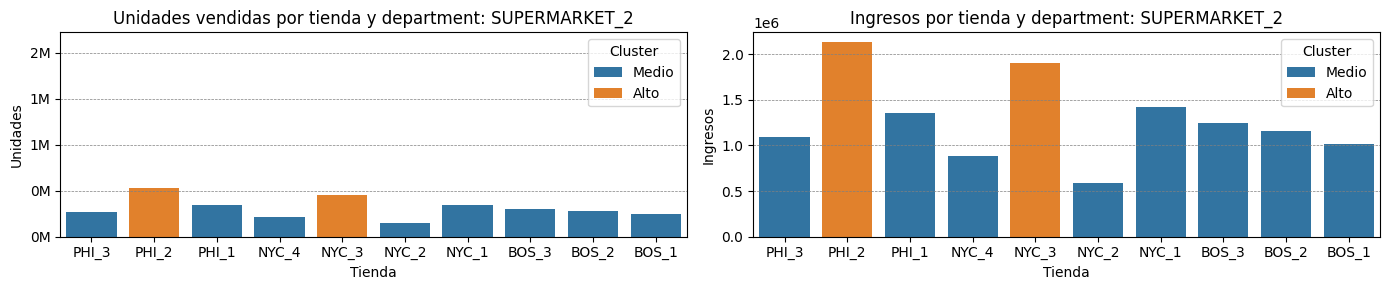

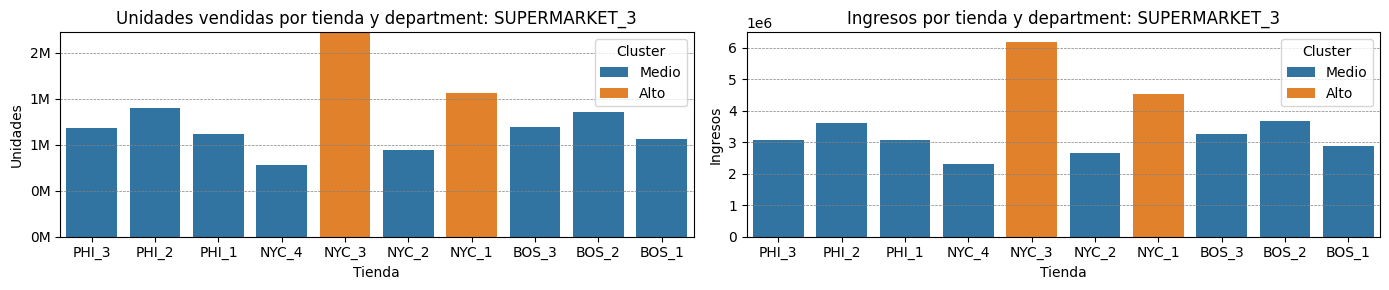

In [59]:
test_clusters(test, shops_clusters_long, target_col='department', it_list=depts_list)

# **********PENDING

# Analisis Adicionales

In [84]:
master_sales = df_origin[['date','store_code','units','raw_earn','category']].copy()

master_sales.head()

,date,store_code,units,raw_earn,category
0,2014-01-01,NYC_1,1,10.99,ACCESORIES
1,2014-01-01,NYC_1,2,12.34,ACCESORIES
2,2014-01-01,NYC_1,1,4.10,ACCESORIES
3,2014-01-01,NYC_1,3,1.84,ACCESORIES
4,2014-01-01,NYC_1,3,11.85,ACCESORIES


In [85]:
# Agrupamos por 'store_code' y 'category' sumando units y raw_earn
grouped_sales = master_sales.groupby(['date', 'store_code', 'category'])[['units', 'raw_earn']].sum().reset_index()

grouped_sales.head()

,date,store_code,category,units,raw_earn
0,2014-01-01,BOS_1,ACCESORIES,119,746.22
1,2014-01-01,BOS_1,HOME_&_GARDEN,523,2438.34
2,2014-01-01,BOS_1,SUPERMARKET,1635,4503.84
3,2014-01-01,BOS_2,ACCESORIES,220,1405.01
4,2014-01-01,BOS_2,HOME_&_GARDEN,556,2567.19


In [82]:
shops_cats_clusters = df_shops_with_clusters[['store_code','ACCESORIES','HOME_&_GARDEN','SUPERMARKET']]

shops_cats_clusters

,store_code,ACCESORIES,HOME_&_GARDEN,SUPERMARKET
0,BOS_1,1,0,1
1,BOS_2,0,0,1
2,BOS_3,0,0,1
3,NYC_1,0,0,0
4,NYC_2,0,0,1
5,NYC_3,0,1,0
6,NYC_4,0,0,1
7,PHI_1,0,0,1
8,PHI_2,1,0,0
9,PHI_3,1,0,1


In [87]:
# Reshape shops_cats_clusters from wide to long format
shops_cats_clusters_long = shops_cats_clusters.melt(id_vars=['store_code'], var_name='category', value_name='category_performance')

# Merge df1 with shops_cats_clusters_long based on 'store_code' and 'category'
sales_clusters = pd.merge(grouped_sales, shops_cats_clusters_long, on=['store_code', 'category'], how='left')

sales_clusters

,date,store_code,category,units,raw_earn,category_performance
0,2014-01-01,BOS_1,ACCESORIES,119,746.22,1
1,2014-01-01,BOS_1,HOME_&_GARDEN,523,2438.34,0
2,2014-01-01,BOS_1,SUPERMARKET,1635,4503.84,1
3,2014-01-01,BOS_2,ACCESORIES,220,1405.01,0
4,2014-01-01,BOS_2,HOME_&_GARDEN,556,2567.19,0
...,...,...,...,...,...,...
21847,2015-12-31,PHI_2,HOME_&_GARDEN,1865,7569.06,0
21848,2015-12-31,PHI_2,SUPERMARKET,3666,12588.02,0
21849,2015-12-31,PHI_3,ACCESORIES,332,1835.57,1
21850,2015-12-31,PHI_3,HOME_&_GARDEN,1110,4762.41,0


In [80]:
shops_dict

,store_code,category_performance
0,BOS_1,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': ..."
1,BOS_2,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
2,BOS_3,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
3,NYC_1,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
4,NYC_2,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
5,NYC_3,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Alto'..."
6,NYC_4,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
7,PHI_1,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo'..."
8,PHI_2,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': ..."
9,PHI_3,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': ..."


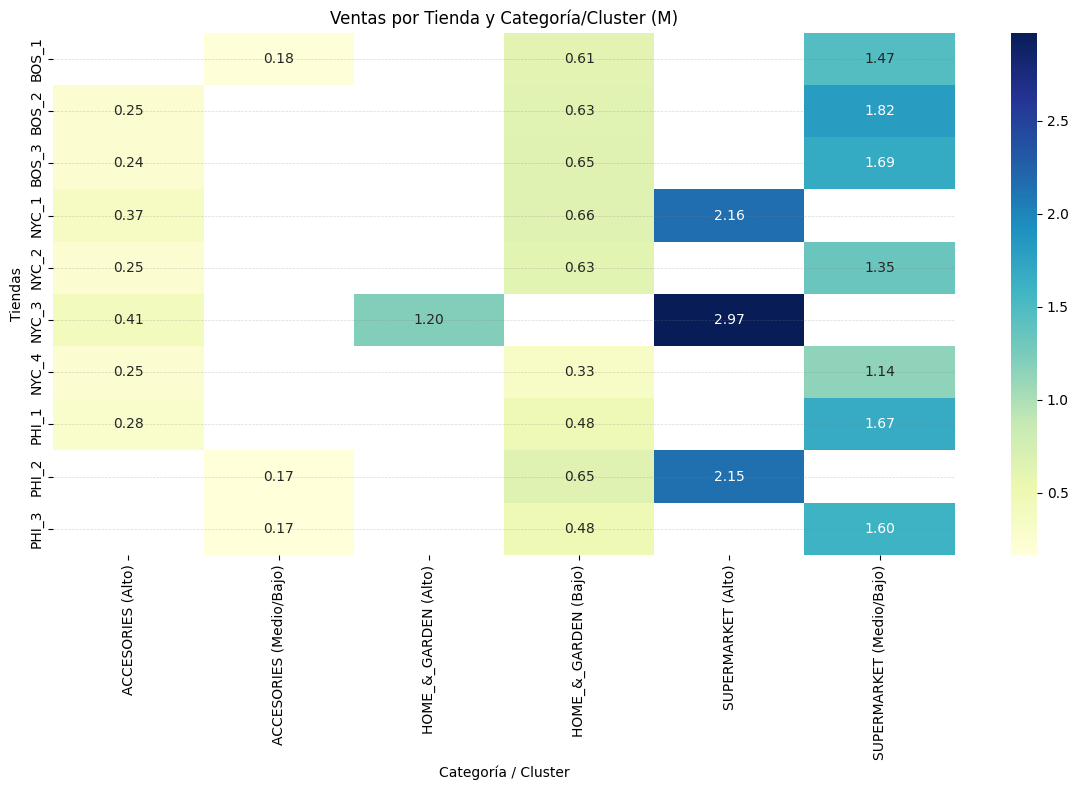

In [98]:
clusters_dict = {
    'ACCESORIES': {0: 'Alto', 1: 'Medio/Bajo'},
    'HOME_&_GARDEN': {0: 'Bajo', 1: 'Alto'},
    'SUPERMARKET': {0: 'Alto', 1: 'Medio/Bajo'}
}

# Función para reemplazar los valores 0/1 por etiquetas del diccionario
def replace_performance(row):
    category = row['category']
    performance = row['category_performance']
    return clusters_dict[category][performance]

# Reemplazar las etiquetas en el DataFrame
sales_clusters['category_performance_label'] = sales_clusters.apply(replace_performance, axis=1)

# Expresar las unidades en millones (M)
sales_clusters['units_million'] = sales_clusters['units'] / 1_000_000

# Crear una columna combinada de categoría y etiqueta de rendimiento
sales_clusters['category_cluster'] = sales_clusters['category'] + " (" + sales_clusters['category_performance_label'] + ")"

# Agrupar por tienda y categoría-cluster, sumando las ventas (units en M)
store_category_performance_sales = sales_clusters.groupby(['store_code', 'category_cluster'])['units_million'].sum().unstack()

# Gráfico de calor (heatmap) por tienda y categoría-cluster
plt.figure(figsize=(12, 8))
sns.heatmap(store_category_performance_sales, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Ventas por Tienda y Categoría/Cluster (M)')
plt.ylabel('Tiendas')
plt.xlabel('Categoría / Cluster')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', color='grey', linewidth=0.5, alpha=0.3)
plt.show()

# Guardar CSV

In [120]:
# mostramos contenido completo de columnas de texto
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
shops_dict

,store_code,category_performance
0,BOS_1,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"
1,BOS_2,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"
2,BOS_3,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"
3,NYC_1,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Alto'}"
4,NYC_2,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"
5,NYC_3,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Alto', 'SUPERMARKET': 'Alto'}"
6,NYC_4,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"
7,PHI_1,"{'ACCESORIES': 'Alto', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"
8,PHI_2,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Alto'}"
9,PHI_3,"{'ACCESORIES': 'Medio/Bajo', 'HOME_&_GARDEN': 'Bajo', 'SUPERMARKET': 'Medio/Bajo'}"


In [115]:
# Guardamos df como csv
from google.colab import files

file_name = 'shops_cats_performance.csv'

# Exportar DataFrame a CSV (reemplaza 'df' por el nombre de tu DataFrame)
shops_dict.to_csv(file_name, index=False)

# Descargar el archivo CSV
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>